In [1]:
import torch
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pylab as plt
import random
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns

#Устанавливаем значения seed для воспроизводимости результатов
random.seed(222)
np.random.seed(222)
torch.cuda.manual_seed(222)
torch.manual_seed(222)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [2]:
#Создадим dataloader для train  и validation для данных, полученных в этапе предобработки
train_transform = transforms.Compose([
    
    #Агументация
    transforms.RandomHorizontalFlip(p = 0.3),
    
    transforms.RandomApply(torch.nn.ModuleList([
        transforms.RandomRotation(degrees = (-12, 12)),
        transforms.GaussianBlur((3,3)) 
    ]), p = 0.3),
    
    transforms.RandomApply(torch.nn.ModuleList([
    transforms.ColorJitter(),
    ]), p=0.3),
    
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_dataset = torchvision.datasets.ImageFolder('train/', train_transform)
val_dataset = torchvision.datasets.ImageFolder('validation/', val_transform)

batch_size = 10
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

In [3]:
#Загрузим предобученный ResNet50
model = torchvision.models.resnet50(pretrained=True)

In [4]:
#model

In [5]:
#Заморозим все слои, кроме последнего, который будем обучать
for layer, param in model.named_parameters():
    if 'layer4' not in layer:
        param.requires_grad = False

#Нейтрализуем резкий переход из 2048 нейронов, а также на выходе сделаем только два, так как задача бинарной классификации
model.fc = torch.nn.Sequential(torch.nn.Linear(2048, 512),
                                 torch.nn.ELU(),
                                 torch.nn.Dropout(0.2),
                                 torch.nn.Linear(512, 2),
                                 torch.nn.Sigmoid())
model = model.to(device) #Перенесем модель на gpu

In [6]:
#Для удобства создадим класс для обучения, валидации и теста обучаемой модели
class TrainValModel:
    def __init__(self, model, loss, optimizer, scheduler, num_epoch, train_dataloader, val_dataloader, max_f1 = 0.94):
        self.model = model #Созданная модель
        self.loss = loss #Функция потерь
        self.optimizer = optimizer #Используемый оптимизатор
        self.scheduler = scheduler #Планировщик шага
        self.num_epoch = num_epoch #Количество эпох
        self.train_dataloader = train_dataloader #Обучающий датасет
        self.val_dataloader = val_dataloader #Валидационный датасет
        
        #Для сохранения истории обучения
        self.loss_hist_train = []
        self.f1_hist_train = []
        
        self.loss_hist_validation = []
        self.precision_hist_validation = []
        self.recall_hist_validation = []
        self.f1_hist_validation = []
        self.max_f1 = max_f1 #Для сохранения лучших моделей
        
    #Метод для обучения и валидации на каждой эпохе    
    def fit(self):
        for epoch in range(self.num_epoch):
            print('Epoch ', epoch)
            #Запускаем обучение
            for phase in ['train', 'validation']:
                
                    if(phase == 'train'):
                        self.model.train()
                        dataloader = self.train_dataloader
                    else:
                        self.model.eval()
                        dataloader = self.val_dataloader
                
                    running_loss = 0
                    preds_classes = torch.Tensor([]).cuda()
                    reals_classes = torch.Tensor([]).cuda()
        
                    #Проходим по всему датасету по батчам
                    for (idx, batch) in enumerate(dataloader):
                        
                        imgs = batch[0].to(device) #Переносим изображения на gpu
                        labels = batch[1].to(device) #Переносим метки классов на gpu
                        
                        self.optimizer.zero_grad()
                        
                        preds = self.model(imgs) #прогноз
                        loss_value = self.loss(preds, labels) #Вычисляем лосс
                        preds_class = preds.argmax(dim = 1)
                        
                        if(phase == 'train'):
                            loss_value.backward() #Вычисляем градиент
                            self.optimizer.step() #Совершаем шаг
                        
                        running_loss += loss_value.item()
                        preds_classes = torch.cat((preds_classes, preds_class), dim = 0)
                        reals_classes = torch.cat((reals_classes, labels.data), dim = 0)
                    
                    #Вычисляем нужные метрики и значение loss-функции    
                    epoch_loss = running_loss / len(dataloader)
                    epoch_f1 = f1_score(preds_classes.cpu(), reals_classes.cpu())
                    epoch_recall = recall_score(preds_classes.cpu(), reals_classes.cpu())
                    epoch_precision = precision_score(preds_classes.cpu(), reals_classes.cpu())
                    
                    #Сохраняем информацию о метриках и выводим информацию о результатах текущей эпохи
                    if(phase == 'train'):
                        self.loss_hist_train.append(epoch_loss)
                        self.f1_hist_train.append(epoch_f1)
                        print("{} Loss: {:.4f} f1: {:.4f}".format('Train', epoch_loss, epoch_f1))
                        print("Recall: ", round(epoch_recall, 4), ' Precision: ', round(epoch_precision, 4), '\n')
                    else:
                        
                        self.loss_hist_validation.append(epoch_loss)
                        self.f1_hist_validation.append(epoch_f1)
                        self.recall_hist_validation.append(epoch_recall)
                        self.precision_hist_validation.append(epoch_precision)
                        self.scheduler.step(epoch_f1)
                        
                        #Если f1 выше ранее полученного максимального значения, то сохраняем модель
                        if(epoch_f1 >= self.max_f1):
                            torch.save(model.state_dict(), "best_model_f1_"+str(round(epoch_f1, 2)) + '.pth')
                            self.max_f1 = epoch_f1
    
                        print("{} Loss: {:.4f} f1: {:.4f}".format('test', epoch_loss, epoch_f1))
                        print("Recall: ", round(epoch_recall, 4), ' Precision: ', round(epoch_precision, 4), '\n')
                        
    
    #Функция для построения графика loss-функции на train и validation
    def show_loss(self):
        plt.figure(figsize = (14, 8))
        plt.plot(self.loss_hist_train, label = 'Train loss')
        plt.plot(self.loss_hist_validation, label = 'Validation loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    
    #Функция для построения графика f1-score на train и validation, а также recall и precision на validation
    def show_result(self):
        plt.figure(figsize = (14, 8))
        plt.plot(self.f1_hist_train, label = 'Train f1')
        plt.plot(self.f1_hist_validation, label = 'Validation f1')
        plt.plot(self.recall_hist_validation, label = 'Validation recall')
        plt.plot(self.precision_hist_validation, label = 'Validation precision')
        plt.xlabel('Epoch')
        plt.ylabel('F1')
        plt.legend()
        plt.show()
    
    #Функция для итогового тестирования модели
    def test(self, test_dataloader):
        model.eval()    

        preds_classes = torch.Tensor([]).cuda()
        real_classes = torch.Tensor([]).cuda()
        for (idx, batch) in enumerate(test_dataloader):
            batch[0] = batch[0].to(device)
            batch[1] = batch[1].to(device)
            
            preds = model.forward(batch[0])
            preds_class = preds.argmax(dim = 1)
            preds_classes = torch.cat((preds_classes, preds_class), dim = 0)
            real_classes = torch.cat((real_classes, batch[1].data), dim = 0)        

        f1 = f1_score(real_classes.cpu(), preds_classes.cpu())
        recall = recall_score(real_classes.cpu(), preds_classes.cpu())
        precision = precision_score(real_classes.cpu(), preds_classes.cpu())
    
        print("Result: ")
        print("f1: ", round(f1, 2))
        print('Recall', round(recall, 2))
        print('Precision: ', round(precision, 2))
        sns.heatmap(confusion_matrix(real_classes.cpu(), preds_classes.cpu()), annot=True, fmt='g', cmap=plt.cm.Blues)
        plt.xlabel('True label')
        plt.ylabel('Predicted label')
        plt.show()

In [7]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002, weight_decay = 0.05)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode = 'max',
                                                       patience = 5,
                                                       verbose = True,
                                                       factor = 0.5, min_lr=0.00001)

In [8]:
num_epoch = 30
trainval = TrainValModel(model, loss, optimizer, scheduler, num_epoch, train_dataloader, val_dataloader)

In [9]:
#Запустим обучение
trainval.fit()

Epoch  0
Train Loss: 0.4520 f1: 0.8631
Recall:  0.8708  Precision:  0.8557 

test Loss: 0.3823 f1: 0.8974
Recall:  0.8333  Precision:  0.9722 

Epoch  1
Train Loss: 0.4257 f1: 0.9319
Recall:  0.9277  Precision:  0.936 

test Loss: 0.4004 f1: 0.9035
Recall:  0.8583  Precision:  0.9537 

Epoch  2
Train Loss: 0.4432 f1: 0.9293
Recall:  0.9232  Precision:  0.9355 

test Loss: 0.4299 f1: 0.8455
Recall:  0.7536  Precision:  0.963 

Epoch  3
Train Loss: 0.4430 f1: 0.9250
Recall:  0.92  Precision:  0.9301 

test Loss: 0.3872 f1: 0.8298
Recall:  0.975  Precision:  0.7222 

Epoch  4
Train Loss: 0.4377 f1: 0.9306
Recall:  0.9167  Precision:  0.9449 

test Loss: 0.3946 f1: 0.9196
Recall:  0.8879  Precision:  0.9537 

Epoch  5
Train Loss: 0.4345 f1: 0.9375
Recall:  0.9332  Precision:  0.942 

test Loss: 0.3843 f1: 0.9259
Recall:  0.9259  Precision:  0.9259 

Epoch  6
Train Loss: 0.4331 f1: 0.9367
Recall:  0.9301  Precision:  0.9435 

test Loss: 0.4091 f1: 0.8787
Recall:  0.8015  Precision:  0.9722 

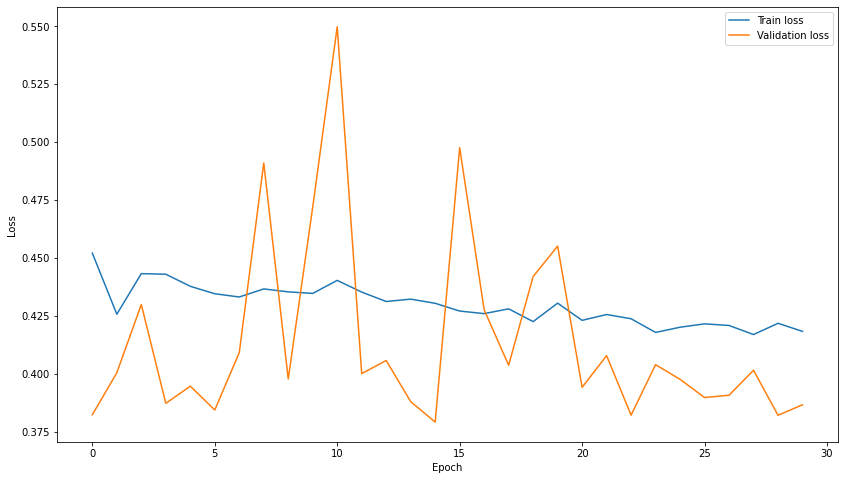

In [10]:
#Посмотрим на график loss-функции на train и validation
trainval.show_loss()

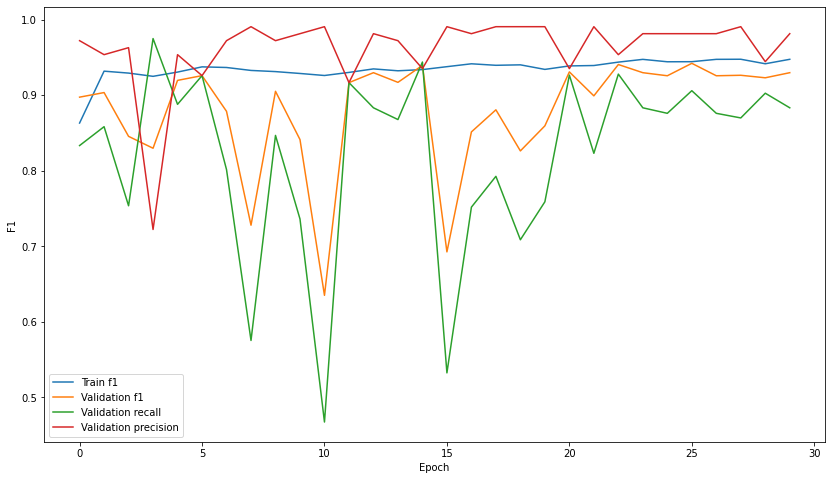

In [11]:
#Посмотрим на значения различных метрик в процессе обучения
trainval.show_result()

## Итоговое тестирование модели

In [12]:
#Test
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

test_dataset = torchvision.datasets.ImageFolder('test/', test_transform)

batch_size_test = 4
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size_test, shuffle = False)

Result: 
f1:  0.93
Recall 1.0
Precision:  0.88


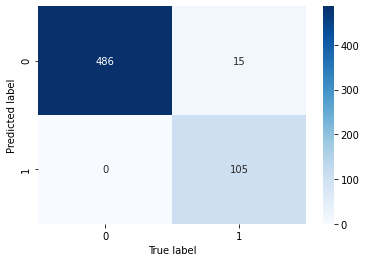

In [13]:
trainval.test(test_dataloader)

In [17]:
torch.save(trainval.model.state_dict(), "model.pth")